# VLBI Cross-Correlation Example

The definition of the cross-correlation is as follows:

$$
R_{12}(\tau) = \lim_{T \to \infty} \frac{1}{2T} \int_{-T}^{T} V_1(t) V_2^*(t - \tau) dt
$$

## Simplest case: Monochromatic Wave
The frequency of the incoming wave is $\nu_0$.

Voltage signals at two antennas are given by:

$$ 
V_1(t) = V_0 e^{i 2 \pi \nu_0 t} \\
V_2(t) = V_0 e^{i 2 \pi \nu_0 (t - \tau_g)} 
$$

Cross-correlation function is calculated as:

$$
\begin{aligned}
R_{12}(\tau) &= V_0^2 \lim_{T \to \infty} \frac{1}{2T} \int_{-T}^{T} e^{i 2 \pi \nu_0 t} V_0 e^{-i 2 \pi \nu_0 [t - (\tau_g + \tau)]} dt \\
&= V_0^2 e^{i 2 \pi \nu_0 (\tau_g + \tau)} \lim_{T \to \infty} \frac{1}{2T} \int_{-T}^{T} dt \\
&= V_0^2 e^{i 2 \pi \nu_0 (\tau_g + \tau)}
\end{aligned}
$$

Then, the cross power spectrum is given by the Fourier transform of $R_{12}(\tau)$:
$$
S_{12}(\nu) = \int_{-\infty}^{\infty} R_{12}(\tau) e^{-i 2 \pi \nu \tau} d\tau = V_0^2 e^{i 2 \pi \nu_0 \tau_g} \delta(\nu - \nu_0)
$$

Thus, 
- $|S_{12}(\nu)|$ have a peak at $\nu = \nu_0$, 
- $\arg [S_{12}(\nu)] = 2 \pi \nu \tau_g$. Data point is located on $\arg [S_{12}(\nu_0)] = 2 \pi \nu_0 \tau_g$.

=== Monochromatic via C->FFT ===
True tau_g = 120.000 ns,  Estimated tau_g ≈ 0.000 ns
[ 9.999525 10.000025 10.000525]
[2.00009500e-08 1.99999500e-08 1.99989501e-08]


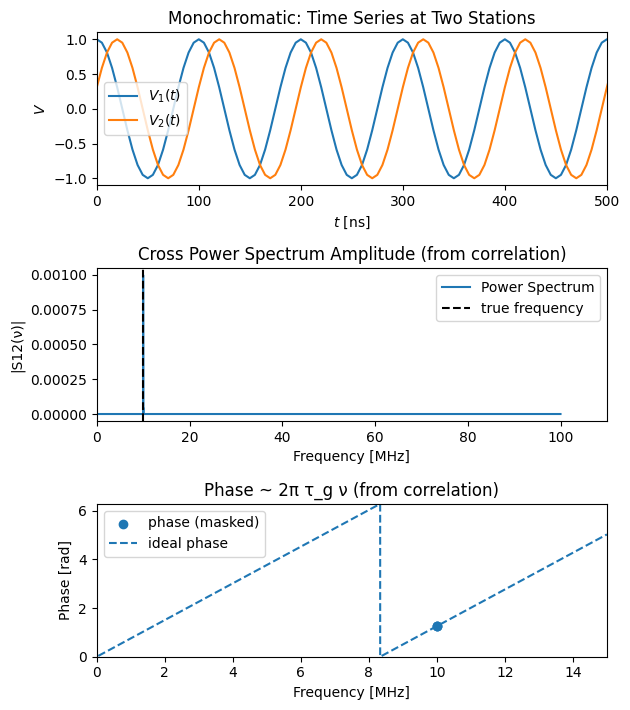

In [68]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt


# ---------- 共通ユーティリティ ----------
def complex_cross_correlation(v1, v2, fs):
    """
    複素相互相関 C12(τ) を計算（FFT 畳み込み）。τ=0 を配列中央に置いて返す。
    Returns:
        lags [s] (len=2N-1), C12 (complex, len=2N-1, fftshift 済み)
    """
    n = len(v1)
    nfft = 2 * n - 1
    V1 = np.fft.fft(v1, nfft)
    V2 = np.fft.fft(v2, nfft)
    C = np.fft.ifft(V1 * np.conj(V2)) / n  # 雑音バイアスは別途
    C = np.fft.fftshift(C)  # τ=0 を中央へ
    lags = np.arange(-n + 1, n) / fs
    return lags, C


def spectrum_from_timeseries(v1, v2, fs):
    """
    参考：従来法（時系列から直接 S12=V1*V2* を作る）
    """
    n = len(v1)
    V1 = np.fft.fftshift(np.fft.fft(v1))
    V2 = np.fft.fftshift(np.fft.fft(v2))
    freqs = np.fft.fftshift(np.fft.fftfreq(n, d=1 / fs))
    S12 = (V1 * np.conj(V2)) / n
    return freqs, S12


def spectrum_from_correlation(lags, C12, fs):
    """
    本題：C12(τ) からフーリエ変換で S12(ν) を得る。
      S12(ν) = ∫ C12(τ) e^{-i2πντ} dτ
    離散化：S ≈ Δτ * FFT{ ifftshift(C12) } を周波数中心に fftshift。
    注意：C12 は中央が τ=0（fftshift 済み）なので ifftshift してから FFT。
    Returns:
        freqs [Hz], S12 (complex)
    """
    dtau = 1.0 / fs
    C_unshift = np.fft.ifftshift(C12)  # τ=0 を先頭へ
    S = dtau * np.fft.fft(C_unshift)  # 連続積分の Δτ を掛ける
    freqs = np.fft.fftfreq(len(C12), d=dtau)  # 相関列のサンプリング間隔は Δτ
    return np.fft.fftshift(freqs), np.fft.fftshift(S)


def fit_delay_from_phase(freqs, phase):
    """
    unwrap 位相 φ(ν) を直線 φ = 2π τ_g ν + φ0 でフィットし τ_g を推定。
    """
    p = np.polyfit(freqs, np.unwrap(phase), 1)
    slope, intercept = p[0], p[1]
    tau_g_est = slope / (2 * np.pi)
    return tau_g_est, intercept


def mask_by_magnitude(freqs, S, frac=0.1, band=None):
    mag = np.abs(S)
    m = mag > (mag.max() * frac)
    if band is not None:
        m &= (freqs >= band[0]) & (freqs <= band[1])
    return m


# ---------- 1) Monochromatic wave case ----------
def demo_monochromatic(
    fs=200e11,  # サンプル周波数
    T=1e-5,  # 観測時間
    nu0=10e6,  # 単一トーン周波数
    tau_g=120e-9,  # 幾何学的遅延 [s]
    V0=1.0,
    add_noise=False,
    snr_linear=50.0,
):
    n = int(T * fs)
    t = np.arange(n) / fs

    v1 = V0 * np.exp(1j * 2 * np.pi * nu0 * t)
    v2 = V0 * np.exp(1j * 2 * np.pi * nu0 * (t - tau_g))

    if add_noise:
        sig_pow = V0**2
        noise_pow = sig_pow / snr_linear
        rng = np.random.default_rng(0)
        v1 = v1 + (
            np.sqrt(noise_pow / 2)
            * (rng.standard_normal(n) + 1j * rng.standard_normal(n))
        )
        v2 = v2 + (
            np.sqrt(noise_pow / 2)
            * (rng.standard_normal(n) + 1j * rng.standard_normal(n))
        )

    # まず C12(τ)
    lags, C12 = complex_cross_correlation(v1, v2, fs)

    # C12 → FFT → S12
    freqs_c, S12_fromC = spectrum_from_correlation(lags, C12, fs)

    # （検証用）時系列から直接の S12
    freqs_d, S12_direct = spectrum_from_timeseries(v1, v2, fs)

    # 位相はピーク周辺のみで直線フィット
    m = mask_by_magnitude(freqs_c, S12_fromC, frac=0.1)
    tau_est, _ = fit_delay_from_phase(freqs_c[m], np.angle(S12_fromC[m]))

    # 同一性チェック（スケーリング差・端点差を無視した近似比較）
    # 相関長は 2N-1 なので周波数グリッド密度が異なる点に注意。
    # ここではピーク近傍の位相・形だけを比較表示します。
    print("=== Monochromatic via C->FFT ===")
    print(
        f"True tau_g = {tau_g * 1e9:.3f} ns,  Estimated tau_g ≈ {tau_est * 1e9:.3f} ns"
    )

    # 可視化
    fig1 = plt.figure(figsize=(6.4, 4.8 * 1.5))

    ax2 = fig1.add_subplot(3, 1, 1)
    ax2.plot(t * 1e9, np.real(v1), label=r"$V_1(t)$")
    ax2.plot(t * 1e9, np.real(v2), label=r"$V_2(t)$")
    ax2.set_xlabel(r"$t$ [ns]")
    ax2.set_ylabel(r"$V$")
    ax2.legend()
    ax2.set_xlim(0, 5 / nu0 * 1e9)
    ax2.set_title("Monochromatic: Time Series at Two Stations")

    # |S12|（C→FFT）
    ax3 = fig1.add_subplot(3, 1, 2)
    ax3.plot(freqs_c * 1e-6, np.abs(S12_fromC), label="Power Spectrum")
    ax3.axvline(nu0 * 1e-6, color="k", linestyle="--", label="true frequency")
    ax3.set_xlabel("Frequency [MHz]")
    ax3.set_ylabel("|S12(ν)|")
    ax3.set_title("Cross Power Spectrum Amplitude (from correlation)")
    ax3.set_xlim(
        0,
    )
    ax3.legend()

    # 位相（ピーク周辺のみ）
    ax4 = fig1.add_subplot(3, 1, 3)
    phase = np.unwrap(np.angle(S12_fromC[m]))
    print(freqs_c[m] * 1e-6)
    print(phase / (2 * np.pi * freqs_c[m]))
    ax4.scatter(freqs_c[m] * 1e-6, phase, label="phase (masked)")
    phase_fit = 2 * np.pi * tau_g * (freqs_c)
    ax4.plot(
        freqs_c * 1e-6,
        np.mod(phase_fit, 2 * np.pi),
        linestyle="--",
        label="ideal phase",
    )
    ax4.set_xlabel("Frequency [MHz]")
    ax4.set_ylabel("Phase [rad]")
    ax4.legend()
    ax4.set_xlim(0, 15)
    ax4.set_ylim(0, 2 * np.pi)
    ax4.set_title("Phase ~ 2π τ_g ν (from correlation)")

    # ax3とax4のx軸を共有
    plt.tight_layout()
    plt.show()


# ---------- 実行例 ----------
if __name__ == "__main__":
    # 1) モノクローム波（C→FFT で S12）
    demo_monochromatic(fs=200e6, T=1e-3, nu0=10e6, tau_g=120e-9, add_noise=False)

    # 2) 連続スペクトル（C→FFT で S12）
    # demo_continuum(fs=400e6, T=2e-3, nu_c=50e6, B=40e6, K=401, tau_g=180e-9, flat_Fnu=True)


## Continuous Wave Case
Next, we consider the case where the incoming signal consists of multiple continuous waves with different frequencies.

Continuous Wave can be approximated by a large number of discrete frequency components, so the results will be a natural extension of the monochromatic wave case.

- Power Spectrum $|S_{12}(\nu)|$ will have peaks at each frequency component.
- Phase $\arg [S_{12}(\nu)]$ will follow the relation $\arg [S_{12}(\nu)] = 2 \pi \nu \tau_g$ at each frequency component.

=== Continuum via C->FFT ===
True tau_g = 180.000 ns,  Estimated tau_g ≈ 179.997 ns


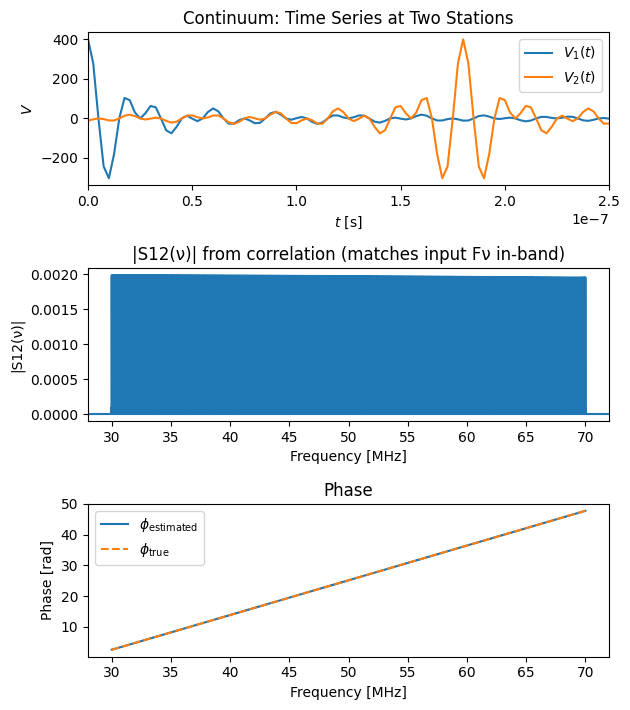

In [69]:
# ---------- 2) Continuous (continuum) wave case ----------
def demo_continuum(
    fs=400e6,  # サンプル周波数
    T=2e-3,  # 観測時間
    nu_c=50e6,  # 中心周波数
    B=40e6,  # 帯域幅
    K=401,  # バンド内のトーン本数
    tau_g=180e-9,
    flat_Fnu=True,
    seed=0,
):
    n = int(T * fs)
    t = np.arange(n) / fs

    # バンド内の周波数グリッド
    freqs_k = np.linspace(nu_c - B / 2, nu_c + B / 2, K)

    # スペクトル形状
    if flat_Fnu:
        Fnu = np.ones_like(freqs_k)
    else:
        Fnu = 0.5 + (freqs_k - freqs_k.min()) / freqs_k.ptp()
    amps = np.sqrt(Fnu)

    v1 = np.zeros(n, dtype=complex)
    v2 = np.zeros(n, dtype=complex)
    # vectorized construction of the signals (no Python loop)
    # amps: (K,), freqs_k: (K,), t: (n,)
    phase = 1j * 2 * np.pi * freqs_k[:, None] * t[None, :]  # shape (K, n)
    v1 = np.sum(amps[:, None] * np.exp(phase), axis=0)
    v2 = np.sum(
        amps[:, None]
        * np.exp(1j * 2 * np.pi * freqs_k[:, None] * (t[None, :] - tau_g)),
        axis=0,
    )

    # まず C12(τ)
    lags, C12 = complex_cross_correlation(v1, v2, fs)

    # C12 → FFT → S12
    freqs_c, S12_fromC = spectrum_from_correlation(lags, C12, fs)

    # 位相フィットは帯域内のみ
    inband = (freqs_c >= (nu_c - B / 2)) & (freqs_c <= (nu_c + B / 2))
    m = (
        mask_by_magnitude(
            freqs_c, S12_fromC, frac=0.05, band=(nu_c - B / 2, nu_c + B / 2)
        )
        & inband
    )
    tau_est, _ = fit_delay_from_phase(freqs_c[m], np.angle(S12_fromC[m]))

    print("=== Continuum via C->FFT ===")
    print(
        f"True tau_g = {tau_g * 1e9:.3f} ns,  Estimated tau_g ≈ {tau_est * 1e9:.3f} ns"
    )

    # 可視化
    fig2 = plt.figure(figsize=(6.4, 4.8 * 1.5))

    # 相互相関
    ax1 = fig2.add_subplot(3, 1, 1)
    ax1.plot(t, np.real(v1), label=r"$V_1(t)$")
    ax1.plot(t, np.real(v2), label=r"$V_2(t)$")
    ax1.set_xlabel(r"$t$ [s]")
    ax1.set_ylabel(r"$V$")
    ax1.set_xlim(0, 10 / B)
    ax1.legend()
    ax1.set_title("Continuum: Time Series at Two Stations")

    # |S12|（C→FFT）
    ax2 = fig2.add_subplot(3, 1, 2)
    ax2.plot(freqs_c * 1e-6, np.abs(S12_fromC))
    ax2.set_xlabel("Frequency [MHz]")
    ax2.set_ylabel("|S12(ν)|")
    ax2.set_title("|S12(ν)| from correlation (matches input Fν in-band)")

    # 位相（帯域内のみ）
    ax3 = fig2.add_subplot(3, 1, 3)
    phase = np.unwrap(np.angle(S12_fromC[m]))
    ax3.plot(freqs_c[m] * 1e-6, phase, label=r"$\phi_\mathrm{estimated}$")
    phase_fit = 2 * np.pi * tau_g * (freqs_c[m])
    ax3.plot(
        freqs_c[m] * 1e-6,
        phase_fit - (phase_fit[0] - phase[0]),
        linestyle="--",
        label=r"$\phi_\mathrm{true}$",
    )
    ax3.set_xlabel("Frequency [MHz]")
    ax3.set_ylabel("Phase [rad]")
    ax3.legend()
    ax3.set_title("Phase")

    ax2.set_xlim(ax3.get_xlim())  # 帯域外も少し見えるように
    plt.tight_layout()
    plt.show()


demo_continuum()